In [1]:

import numpy as np
import astropy.units as u
from astropy.io import fits

import scoobpsf
import scoobpsf.ad_scoob as ad_scoob
import scoobpsf.utils as utils
from scoobpsf.math_module import xp, _scipy, ensure_np_array
from scoobpsf.imshows import imshow1, imshow2, imshow3

from importlib import reload

import matplotlib.pyplot as plt
from matplotlib.patches import Circle

from scipy.optimize import minimize

npix = 500
wavelength = 650e-9*u.m
pupil_diam = 9.4*u.mm

15.957446808510637
574


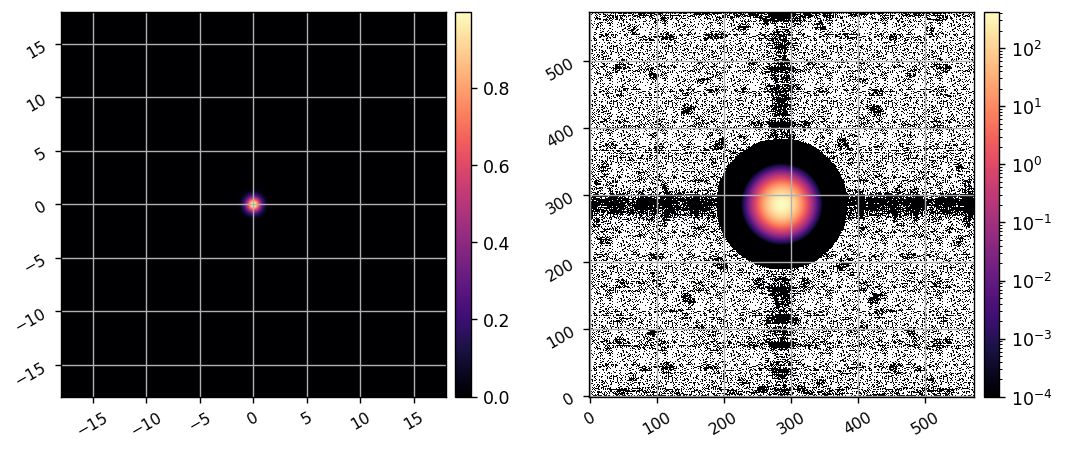

952


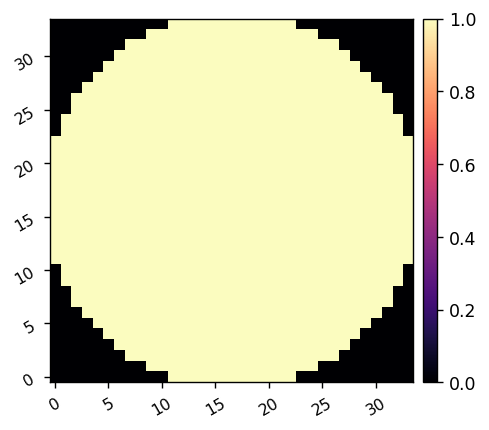

In [2]:
Nact = 34
act_spacing = 0.3*u.mm
inf_sampling = (npix/pupil_diam * act_spacing).value
print(inf_sampling)

reload(ad_scoob)
inf_fun = ad_scoob.make_gaussian_inf_fun(act_spacing=act_spacing, sampling=inf_sampling, 
                                         Nacts_per_inf=Nact + 2, # number of influence functions across the grid
                                         coupling=0.15,)

Nsurf = inf_fun.shape[0]
print(Nsurf)

fourier_inf_fun = xp.fft.fft2(inf_fun, )
imshow2(inf_fun, xp.abs(xp.fft.fftshift(fourier_inf_fun)), pxscl1=1/inf_sampling, grid=True, lognorm2=True, vmin2=1e-4)

# DM command coordinates
xc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)
yc = inf_sampling*(xp.linspace(-Nact//2, Nact//2-1, Nact) + 1/2)

dm_mask = xp.ones((Nact,Nact), dtype=bool)
xx = (xp.linspace(-Nact//2, Nact//2 - 1, Nact) + 1/2)
x,y = xp.meshgrid(xx,xx)
r = xp.sqrt(x**2 + y**2)
dm_mask[r>(Nact/2 + 1/2)] = 0
Nacts = int(xp.sum(dm_mask))
print(Nacts)
imshow1(dm_mask)

# Influence function frequncy sampling
fx = xp.fft.fftfreq(Nsurf)
fy = xp.fft.fftfreq(Nsurf)

# forward DM model MFT matrices
Mx = xp.exp(-1j*2*np.pi*xp.outer(fx,xc))
My = xp.exp(-1j*2*np.pi*xp.outer(yc,fy))

Mx_back = xp.exp(1j*2*np.pi*xp.outer(xc,fx))
My_back = xp.exp(1j*2*np.pi*xp.outer(fy,yc))

Oversampling > 2x suggested for reliable results in Fresnel propagation.


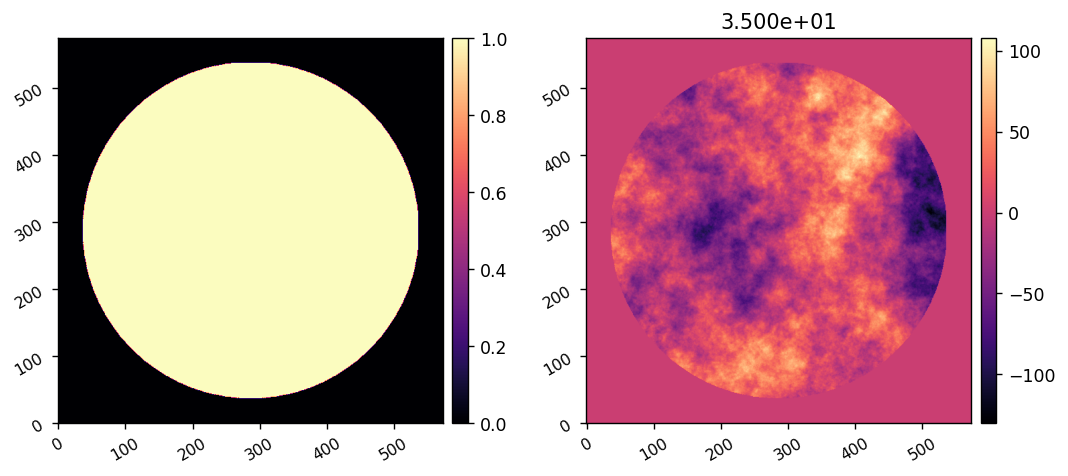

In [8]:
reload(utils)
WFE, mask = utils.generate_wfe(diam=pupil_diam,
                                npix=npix, oversample=1,
                                wavelength=wavelength,
                                opd_index=3, amp_index=3,
                                opd_rms=35*u.nm, amp_rms=0.05,
                                # opd_seed=12, amp_seed=1234,
                                remove_modes=12)

mask = utils.pad_or_crop(mask, Nsurf)
WFE = utils.pad_or_crop(WFE, Nsurf)

wfe_opd = xp.angle(WFE)*wavelength.to_value(u.nm)/2/np.pi
rms_opd = xp.sqrt(xp.mean(xp.square(wfe_opd[mask])))
imshow2(mask, wfe_opd,  '', f'{rms_opd:.3e}')

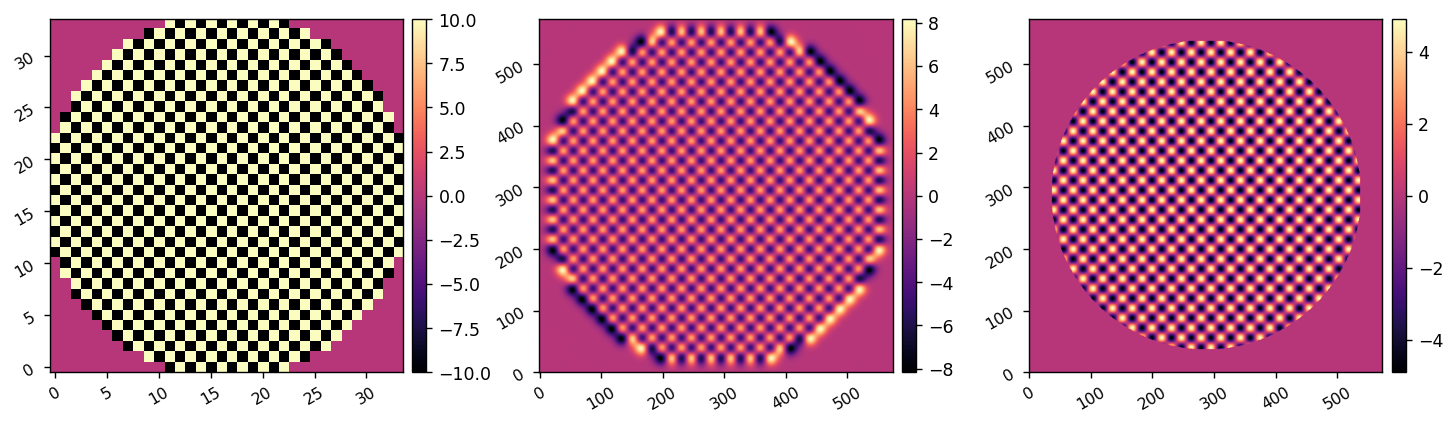

In [10]:
def forward_dm(actuators):
    command = xp.zeros((Nact,Nact))
    command[dm_mask] = actuators
    mft_command = Mx@command@My
    fourier_surf = fourier_inf_fun * mft_command
    surf = xp.fft.ifft2(fourier_surf).real
    return surf

waffle_command = 10 * xp.ones((Nact,Nact))
waffle_command[1::2, ::2] *= -1
waffle_command[::2, 1::2] *= -1
waffle_command *= dm_mask
waffle_surf = forward_dm(waffle_command[dm_mask])
imshow3(waffle_command, waffle_surf, waffle_surf*mask)

In [11]:
wfe_opd[mask].dot(wfe_opd[mask])

array(2.41955875e+08)

In [12]:
def compute_cost_fun(actuators):

    wfe_l2norm = wfe_opd[mask].dot(wfe_opd[mask])

    actuators = xp.array(actuators)
    s_dm = forward_dm(actuators)
    total = wfe_opd[mask] + s_dm[mask]
    J = total.dot(total) / wfe_l2norm # normalizing the cost function by 

    return ensure_np_array(J)

actuators = xp.zeros(Nacts)
J0 = compute_cost_fun(actuators)
print(J0)

1.0


In [10]:
def adjoint_dm(actuators, return_np=False):
    """
    The input is the gradient of a cost-function with respect to 
    the DM surface.

    This function back propagates this gradient to compute the gradient 
    with respect to the DM actuators. 
    """

    actuators = xp.array(actuators)
    s_dm = forward_dm(actuators)
    res = 2 * (wfe_opd + s_dm) /2.4195587499999994e-10

    # x2_bar = xp.fft.fft2(dJ_dsDM)
    x2_bar = xp.fft.fft2(res)
    x1_bar = fourier_inf_fun.transpose().conjugate() * x2_bar
    dJ_dA = Mx_back@x1_bar@My_back
    dJ_dA = dJ_dA[dm_mask].real

    return ensure_np_array(dJ_dA)

In [ ]:
wfe_opd = wfe_opd * 1e9

1.0
(952,)


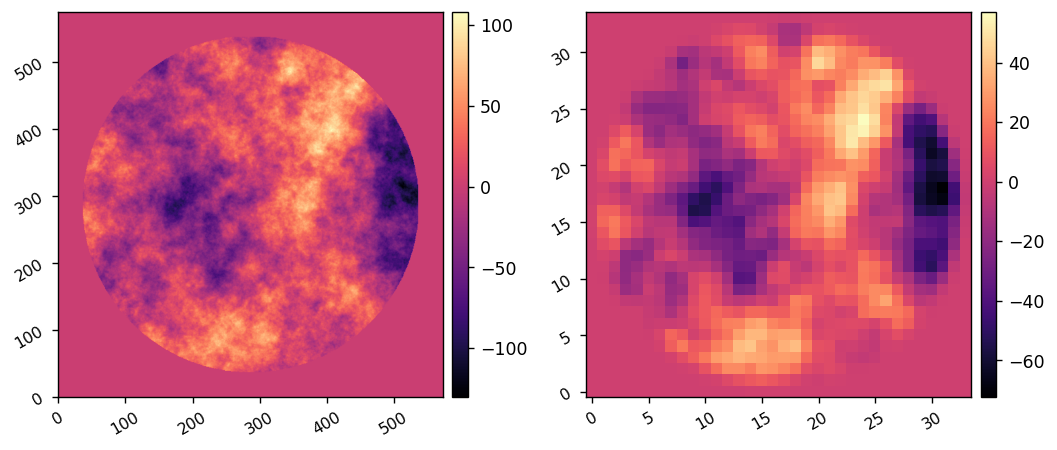

In [17]:
def val_and_grad(actuators):
    wfe_l2norm = wfe_opd[mask].dot(wfe_opd[mask])

    actuators = xp.array(actuators)
    s_dm = forward_dm(actuators)
    total_wfe =  wfe_opd + s_dm
    J = total_wfe[mask].dot(total_wfe[mask]) / wfe_l2norm
    print(J)

    masked_total = mask * total_wfe
    dJ_dwfe = 2 * (masked_total)
    x2_bar = xp.fft.fft2(dJ_dwfe.real)
    x1_bar = fourier_inf_fun.conjugate() * x2_bar
    dJ_dA = Mx_back@x1_bar@My_back / xp.sum(xp.abs(Mx_back))**2
    dJ_dA = dJ_dA[dm_mask].real
    # print(dJ_dA.dot(dJ_dA))

    return ensure_np_array(J), ensure_np_array(dJ_dA)

actuators = xp.zeros(Nacts)
J0, dJ_dA = val_and_grad(actuators)
print(dJ_dA.shape)

dm_grad = xp.zeros((Nact,Nact), dtype=dJ_dA.dtype)
dm_grad[dm_mask] = dJ_dA
imshow2(wfe_opd, dm_grad)


### use the matrix multiplication surface model for the DM just to test the forward and adjoint models
### implement DM model with Jax and then have minimize operate with the val_and_grad function from Jax
### implement unit testable forward and adjoint models

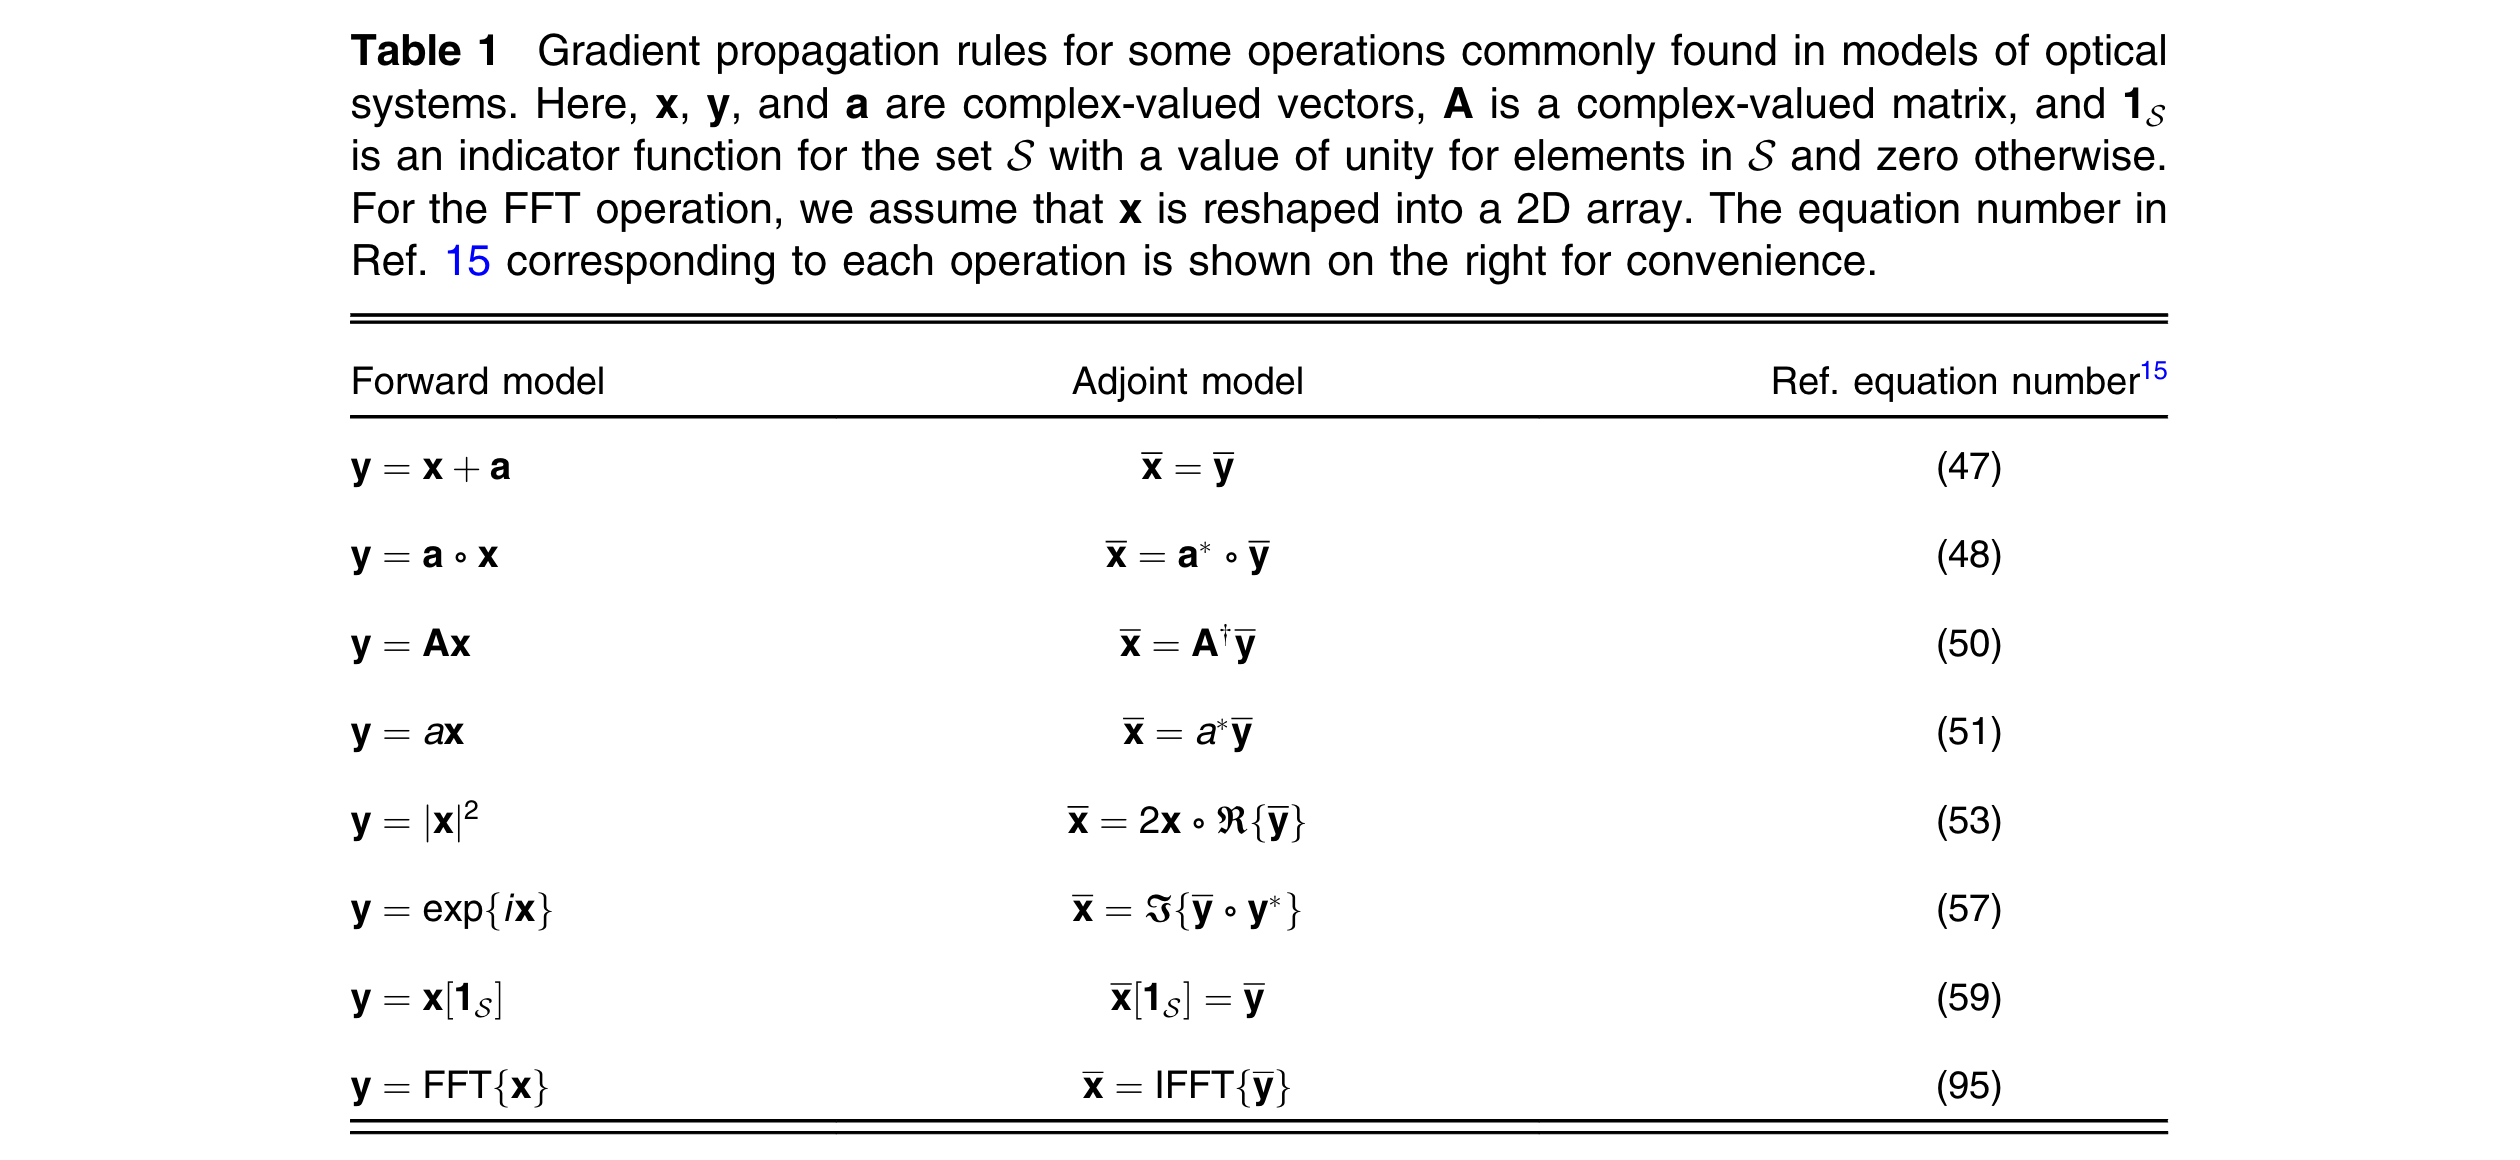

1.0
0.1013513598419236
0 0.8986486401580764
0.06595745369372323
1 0.34921984474015727
0.058082679518700296
2 0.11939172502913539
0.054307305348251914
3 0.06500000002983443
0.05210114360702345
4 0.04062366429490833
0.05068425266568225
5 0.027195006543967563
0.04971567999309323
6 0.019109932999857172
0.049022447521280085
7 0.013943940260084015
0.04850812237712508
8 0.01049162516685322
0.04811521061926061
9 0.008099916851239748
0.04780764856930106
10 0.006392200013282911
0.04756188316388778
11 0.005140713102779452
0.047362008920786035
12 0.00420240389584702
0.04719697331753594
13 0.003484556652276345
0.047058901692745486
14 0.0029254338802940107
0.04694205762859662
15 0.0024829322390853233
0.046842178376827165
16 0.002127713543357997
0.046756038965500506
17 0.0018389283827430277
0.046681159695098326
18 0.0016014887500934432
0.046615605767321724
19 0.0014042909003283586
0.046557847413503814
20 0.0012390347152455117
0.04650666053921394
21 0.0010994252770162418
0.046461054995664164
22 0.0009

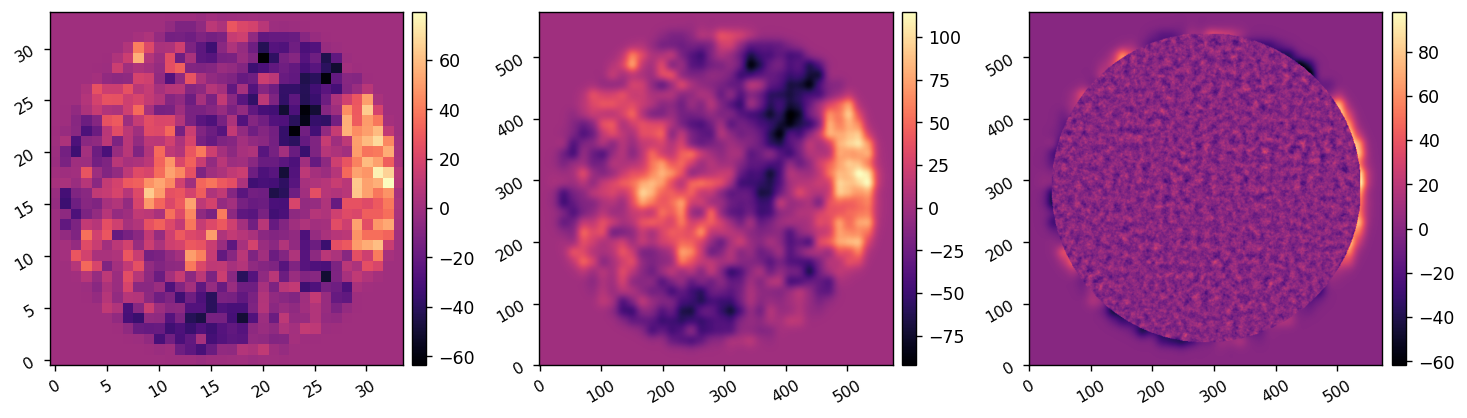

In [19]:
del_acts = np.zeros(Nacts)
J, dJ_dA = val_and_grad(del_acts)
J_prev = J
tol = 1e-3

for i in range(50):
    del_acts -=  dJ_dA
    J, dJ_dA = val_and_grad(del_acts)
    print(i, (J_prev-J)/J_prev)
    if (J_prev-J)/(J_prev)<tol:
        break
    J_prev = J

dm_command = xp.zeros((Nact,Nact), dtype=dJ_dA.dtype)
dm_command[dm_mask] = del_acts
s_dm = forward_dm(del_acts)

imshow3(dm_command, s_dm, wfe_opd+s_dm)


scipy.optimize.approx_fprime

In [23]:
options = {
    'disp':True, 
    'maxiter':20,
    # 'maxls':30, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-9,
    # 'PGTOL':1e-8,
}

del_acts0 = np.zeros(Nacts)
# del_acts0 = np.random.randn(Nacts) * 1e-9
result = minimize(val_and_grad, 
                  jac=True, 
                  x0=del_acts0, 
                  method='L-BFGS-B',
                #   method='CG',
                  tol=1e-3,
                  options=options,
                  )

dm_command = result['x']

1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  7.24137D+01
0.9969397553836067
0.9993533103683153
0.9998634856347405
0.9999711886072549
0.9999939196333041
0.9999987168099318
0.999999729198354
0.9999999428506339
0.9999999879393283
0.9999999974547435
0.999999999462855
0.9999999998866423
0.9999999999760775
0.9999999999949514
0.9999999999989349
0.9999999999997753
0.9999999999999527
0.9999999999999901
0.999999999999998
0.9999999999999997

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
  952      1     21      1     0     0   7.241D+01   1.000D+00
  F =   1.0000000000000000     

ABNORMAL_TERMINATION_IN_LNSRCH                              
